# Exploratory Data Analysis
---  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn
import datetime
import statsmodels.api as sm

from pylab import rcParams

In [45]:
from statsmodels.tsa.arima_model import ARIMA

In [2]:
import matplotlib.style as style 

style.use('seaborn-darkgrid')
sns.set_context('notebook')
sns.set_palette('husl')

In [3]:
test = pd.read_csv('wrangled_data/testing_post_wrangle.csv', 
                       dtype={'shop_id':'int8', 
                            'item_id':'int16',
                            'year':'int16',
                            'month':'int8',
                            'date_block_num':'int8',
                            'mean_item':'float64',
                            'mode_item':'float64'})

train = pd.read_csv('wrangled_data/training_post_wrangle.csv', 
                       dtype={'shop_id':'int8', 
                            'item_id':'int16',
                            'year':'int16',
                            'month':'int8',
                            'item_cnt_month':'int32',
                            'date_block_num':'int8',
                            'mean_item':'float64',
                            'mode_item':'float64'})

In [4]:
train.shape

(14411682, 12)

In [5]:
train.head(3)

,shop_id,item_id,year,month,item_cnt_month,date_block_num,mean_item,mode_item,item_name,item_category_id,item_category_name,shop_name
0,0,30,2013,2,31,1,0.911765,0.0,30,40,40,0
1,0,30,2013,1,0,0,0.911765,0.0,30,40,40,0
2,0,30,2013,6,0,5,0.911765,0.0,30,40,40,0


In [6]:
test.shape

(214200, 12)

In [7]:
test.head(3)

,ID,shop_id,item_id,month,year,date_block_num,mean_item,mode_item,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,11,2015,34,0.382353,0.0,5036,19,19,5
1,1,5,5320,11,2015,34,0.000000,0.0,5319,55,55,5
2,2,5,5233,11,2015,34,0.294118,0.0,5232,19,19,5


### Time Series Analysis

In [8]:
train['date'] = pd.to_datetime(train[['year', 'month']].assign(DAY=1)).apply(lambda x: x.strftime('%Y-%m'))
# train.drop(columns=['year', 'month'], inplace=True)

In [9]:
train.index = train['date']

In [10]:
train[(train['shop_id'] == 2)].groupby('item_id')['item_cnt_month'].sum().sort_values(ascending=False).head()

item_id
20949    1319
3732      239
17717     222
6675      213
4872      196
Name: item_cnt_month, dtype: int32

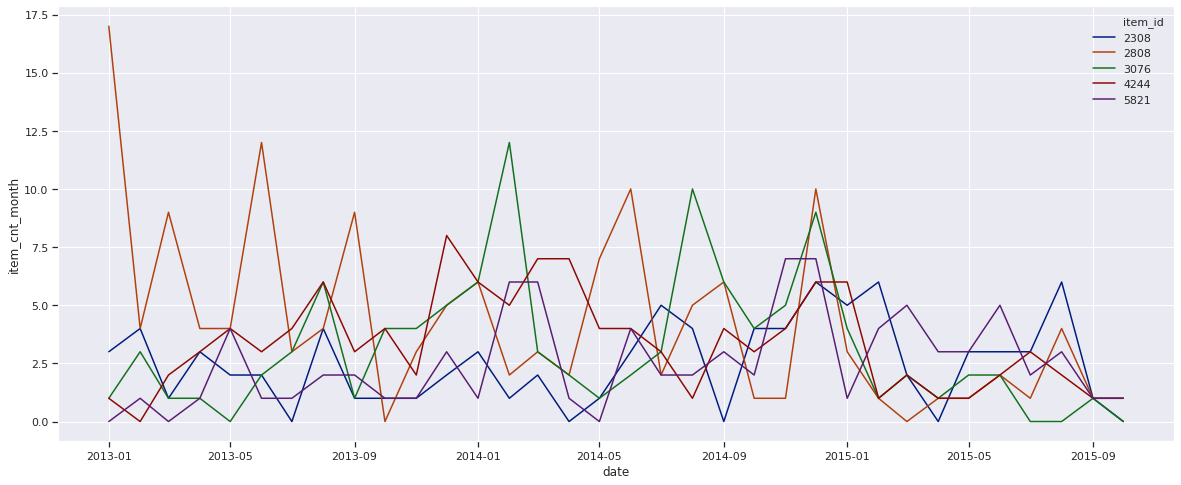

In [11]:
plt.figure(figsize=(20,8))

shop = train[(train['shop_id'] == 2)]
shop = shop[shop['item_id'].isin([4244, 2808, 5821, 3076, 2308])] 
shop = shop.set_index(pd.DatetimeIndex(shop['date']))
shop.drop(columns=['date'], inplace=True)
sns.lineplot(data=shop, x=shop.index, y='item_cnt_month', hue='item_id', palette='dark')

In [12]:
returns = shop[shop['item_id']==5821]['item_cnt_month'].pct_change()
autocorrelation = returns.autocorr()
print("The autocorrelation of items sold each month is %4.2f" %(autocorrelation))

The autocorrelation of items sold each month is  nan


In [13]:
returns = shop[shop['item_id']==5821]['item_cnt_month'].diff()
autocorrelation = returns.autocorr()
print("The autocorrelation of items sold each month is %4.2f" %(autocorrelation))

The autocorrelation of items sold each month is -0.51


In [14]:
resample = shop[shop['item_id']==5821].resample('Y')['item_cnt_month'].mean().reset_index().rename(columns={'item_cnt_month':'year_mean'})
resample['year'] = resample['date'].dt.year
resample.drop(columns=['date'], inplace=True)

ret = pd.merge(shop[shop['item_id']==5821].reset_index(), resample, how='left', on='year')
ret.index = ret['date']
ret.sort_index(inplace=True, ascending=True)
# ret.drop(columns=['date'], inplace=True)

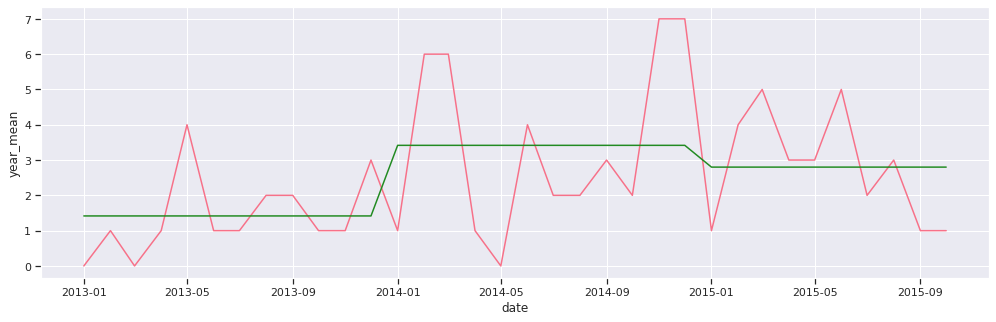

In [15]:
plt.figure(figsize=(17,5))

sns.lineplot(data=ret, x='date', y='item_cnt_month')
sns.lineplot(data=ret, x='date', y='year_mean', color='forestgreen')
plt.legend(['item_cnt_month', 'year_average'])

In [16]:
# v = int(len(ret)/4) if 0 != 0 else 1

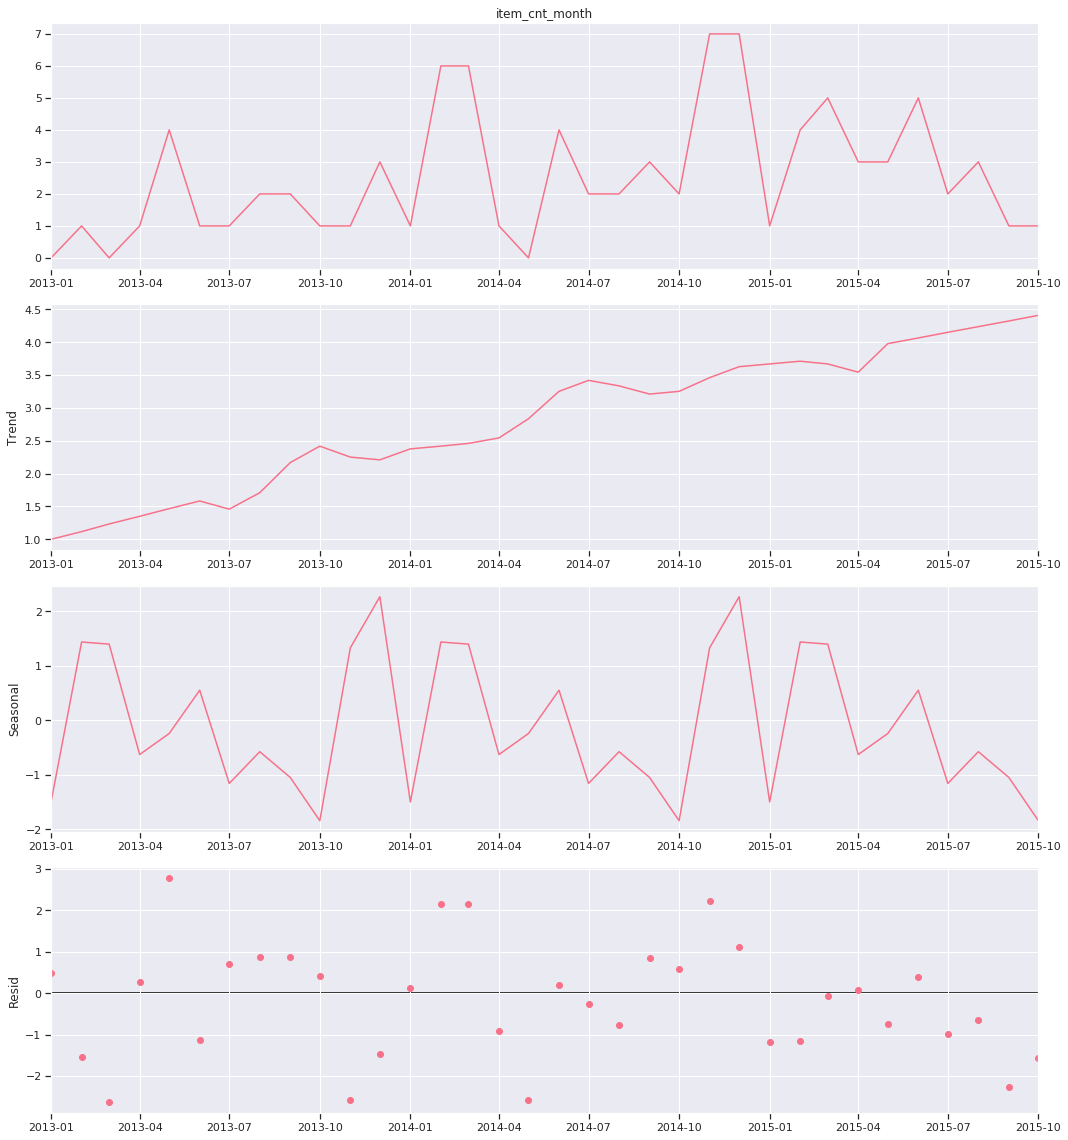

In [17]:
rcParams['figure.figsize'] = 15, 16

decomposition = sm.tsa.seasonal_decompose(ret['item_cnt_month'], model='additive', extrapolate_trend='freq', period=12)
decomposition.plot()
plt.show()

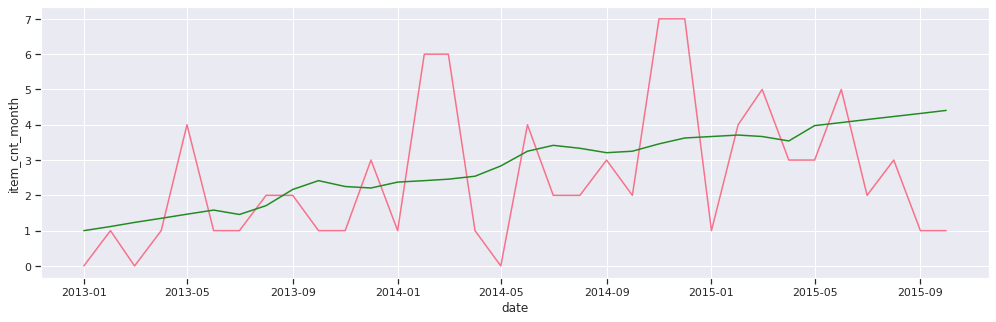

In [18]:
plt.figure(figsize=(17,5))
sns.lineplot(data=ret, x='date', y='item_cnt_month')
plt.plot(decomposition.trend, color='forestgreen')
plt.legend(['item_cnt_month', 'trend'])

In [26]:
train.sort_index(inplace=True, ascending=True)

In [19]:
train.shape

(14411682, 13)

In [48]:
ret['item_cnt_month'].tail(2)

date
2015-09-01    1
2015-10-01    1
Name: item_cnt_month, dtype: int32

In [20]:
train.head(2)

,shop_id,item_id,year,month,item_cnt_month,date_block_num,mean_item,mode_item,item_name,item_category_id,item_category_name,shop_name,date
date,,,,,,,,,,,,,
2013-02,0,30,2013,2,31,1,0.911765,0.0,30,40,40,0,2013-02
2013-01,0,30,2013,1,0,0,0.911765,0.0,30,40,40,0,2013-01


---  
---  
### Time Series Decomposition

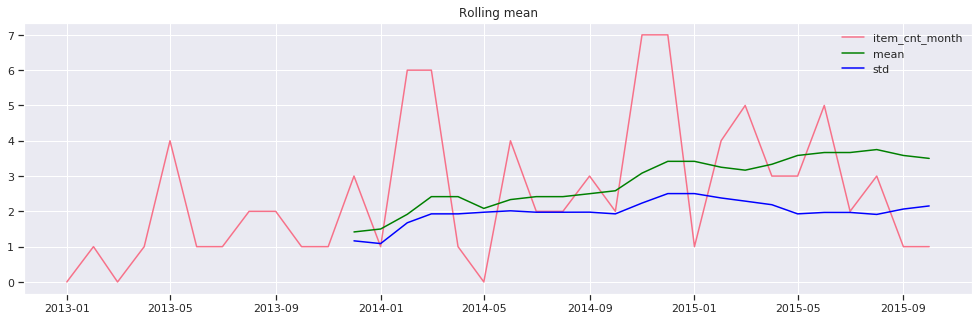

In [43]:
plt.figure(figsize=(17,5))
plt.plot(ret['item_cnt_month'])
plt.plot(ret['item_cnt_month'].rolling(window = 12).mean().dropna(), color='g')
plt.plot(ret['item_cnt_month'].rolling(window = 12).std().dropna(), color='blue')
plt.title('Rolling mean')
plt.legend(['item_cnt_month', 'mean', 'std'])

In [46]:
arima_model = ARIMA(ret['item_cnt_month'], order=(5,2,1)).fit(transparams=False)
arima_model.summary()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D2.item_cnt_month   No. Observations:                   32
Model:                 ARIMA(5, 2, 1)   Log Likelihood                 -69.934
Method:                       css-mle   S.D. of innovations  5446224845498.434
Date:                Fri, 18 Dec 2020   AIC                            155.868
Time:                        13:49:00   BIC                            167.593
Sample:                    03-01-2013   HQIC                           159.754
                         - 10-01-2015                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0283      0.064     -0.443      0.658      -0.154       0.097
ar.L1.D2.item_cnt_month    -1.3293      0.358     -3.712      0.000      -2.031      -0.627
ar.L2.D2.item_cnt_month    -1.6031      0.436     -3.675      0.000      -2.458      -0.748
ar.L3.D2.item_cnt_month    -1.3048      0.490     -2.664      0.008      -2.265      -0.345
ar.L4.D2.item_cnt_month    -0.8550      0.310     -2.760      0.006      -1.462      -0.248
ar.L5.D2.item_cnt_month    -0.4729      0.179     -2.635      0.008      -0.825      -0.121
ma.L1.D2.item_cnt_month     0.0825      0.408      0.202      0.840      -0.717       0.882
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2249           -0.0000j            1.2249           -0.5000
AR.2           -0.5557           -0.9671j            1.1154           -0.3330
AR.3           -0.5557           +0.9671j            1.1154            0.3330
AR.4            0.2641           -1.1481j            1.1781           -0.2140
AR.5            0.2641           +1.1481j            1.1781            0.2140
MA.1          -12.1180           +0.0000j           12.1180            0.5000
-----------------------------------------------------------------------------
"""

In [53]:
pred = arima_model.predict('2015-11-01', '2015-12-01', typ='levels')

In [54]:
pred

2015-11-01    1.154119
2015-12-01    0.569582
Freq: MS, dtype: float64

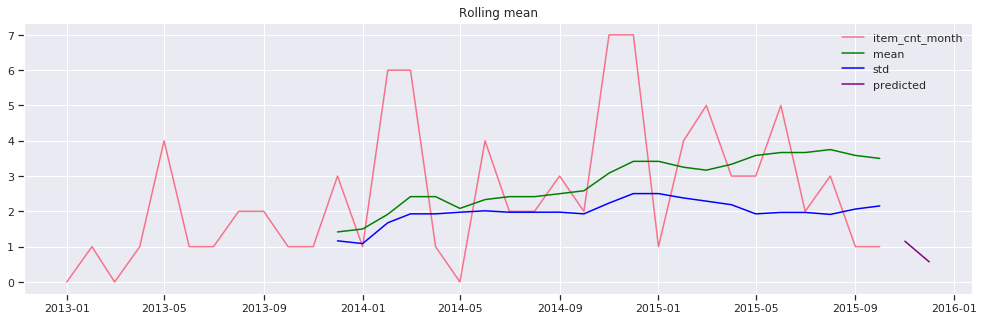

In [57]:
plt.figure(figsize=(17,5))
plt.plot(ret['item_cnt_month'])
plt.plot(ret['item_cnt_month'].rolling(window = 12).mean().dropna(), color='g')
plt.plot(ret['item_cnt_month'].rolling(window = 12).std().dropna(), color='blue')
plt.plot(pred, color='purple')
plt.title('Rolling mean')
plt.legend(['item_cnt_month', 'mean', 'std', 'predicted'])